# **Robot Learning – Reinforcement Learning**

The goal of this practical exercise is to implement a Reinforcement Learning algorithm to learn a policy that moves a robot to a goal position. The algorithm is the Q-learning algorithm.

## The Problem
The problem consists in finding the goal in a finite 2D environment that is closed and contains some obstacles.

**States and actions:** The size of the environment is 20x14=280 states. The robot can only do 4 different actions: {←, ↑, →, ↓} (not diagonal movements!). Therefore the size of the Q function will be 280x4=1120 cells.

**Dynamics:** The robot can be located in any free cell (not in the obstacle cells!). The function that describes the dynamics is very simple: the robot will move ONE cell per iteration to the direction of the action that we select, unless there is an obstacle or the wall in front of it, in which case it will
stay in the same position.

**Reinforcement function:** Since the goal is to reach the goal position as fast as possible, the reinforcement function will give -1 in all cells except in the goal cell, where the reward will be +1. The cell that contains the goal is (3,17).

## Data

Next you have the map that will be used as the environment for the Q-learning algorithm:

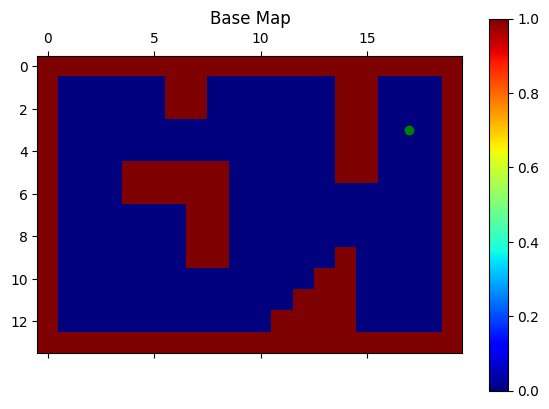

In [32]:
from matplotlib import pyplot as plt
import numpy as np

# Proposed Map
map=[
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


# Convert Map 2D array to Numpy array
grid_map = np.array(map)

# Show grid map
plt.matshow(grid_map, cmap = "jet")
plt.title('Base Map')
plt.colorbar()
plt.scatter(17,3, c = 'g')
plt.show()


## Algorithm

In order to implement the Q-learning algorithm, you should follow the next pseudocode:

```verbatim
Initialize Q(s,a) to 0 or random
For n episodes:
    Initialize s randomly in any free cell
    repeat:
        Choose action 'a' following epsilon-greedy policy
        Take action a, observe r and s'
        Q(s,a) <- Q(s,a) + alpha * (r + gamma * max_a Q(s',a)) - Q(s,a)
        s <- s'
    until the episode terminates
endFor
```

You will have to set several parameters experimentally: n, m, epsilon, alpha and gamma.

## Environment

In the environment class, you set the possible actions, the rewards obtained depending of those actions and the state of the agent after the action is applied.

You have to fill the empty functions following the previous pseudocode.

In [39]:
class MapEnv:
    def __init__(self, map, goal, max_steps):
        self.map = map
        self.current_state = None
        self.goal = goal.astype(np.int32)
        self.actions = 4
        self.steps = 0
        self.valid_rows ,self.valid_cols = np.where(self.map == 0) # Free Cells
        self.max_steps = max_steps
        if map[goal[0], goal[1]] != 0:
            raise ValueError("Goal position is an obstacle")

    def reset(self):
        # start the agent in a random position within the map and return agent state (cell in which it is)
        self.steps = 0
        random_idx = np.random.choice(len(self.valid_rows))
        self.current_state = np.array([self.valid_rows[random_idx], self.valid_cols[random_idx]])
        return self.current_state

    def step(self, action):
      # this function applies the action taken and returns the obtained state, a reward and a boolean that says if the episode has ended (max steps or goal reached) or not (any other case)
      # action: 0 = up, 1 = down, 2 = left, 3 = right

      new_state = self.get_state()# get current state

      # get new_state according to the required action
      match action:
        case 0: # up
          new_state[1] -= 1
        case 1: # down
          new_state[1] += 1
        case 2: # left
          new_state[0] -= 1
        case 3: # right
          new_state[0] += 1

      if new_state[0] < 0 or new_state[0] >= self.map.shape[0] or new_state[1] < 0 or new_state[1] >= self.map.shape[1] or self.map[new_state[0], new_state[1]] == 1:
        new_state = self.current_state # Don't move if will hit obstacle

      self.steps += 1

      if np.array_equal(new_state, self.goal):
        reward = 1
        done = True
      elif self.steps == self.max_steps:
        done = True
        reward = -1
      else:
        done = False
        reward = -1

      return new_state, reward, done

    def get_state(self):
      # returns current state
      return self.current_state

    def render(self, i=0):
        plt.matshow(self.map, cmap = "jet")
        plt.title('Map')
        plt.colorbar()
        plt.scatter(self.current_state[1], self.current_state[0], c = 'r')
        plt.scatter(self.goal[1], self.goal[0], c = 'g')
        plt.savefig("q_learning_{0:04}.png".format(i), dpi = 300)
        plt.show()

In [35]:
np.shape(grid_map)[0]

14

## QLearning algorithm

QLearning class creates and trains the policy at every episode using the information provided by the environment. After the training is over, the optimal policy and the value function are obtained.

As in the MapEnv class, you have to fill the empty functions following the previous pseudocode.

In [37]:
from re import S
class QLearning:
    def __init__(self, env, alpha, gamma, epsilon, n_episodes):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_episodes = n_episodes
        self.Q = np.random.rand(env.map.shape[0], env.map.shape[1], env.actions)

    def epsilon_greedy_policy(self, s, epsilon):
        # Epsilon greedy policy (choose a random action with probability epsilon)
        if np.random.rand() < epsilon:
            return np.random.randint(0, self.env.actions)
        else:
            return np.argmax(self.Q[s[0], s[1]])

    def episode(self, alpha, epsilon):
        # Episode execution. Generate an action with epsilon_greedy_policy, call step, appy learning function
        # This function should return the total reward obtained in this episode
        s = self.env.reset()
        done = False
        total_reward = 0
        while not done:
            a = self.epsilon_greedy_policy(s, epsilon)
            s_prime, reward, done = self.env.step(a)
            self.Q[s[0], s[1], a] += alpha * (reward + self.gamma * np.max(self.Q[s_prime[0], s_prime[1]]) - self.Q[s[0], s[1], a])
            s = s_prime
            total_reward += reward
        self.env.reset()
        return total_reward

    def train(self, n_episodes, check_every_n=100):
        """Execute n_episodes and every `check_every_n` episodes print the average reward and store it.
           As the initial position is random, this number will not be super stable..."""
        rewards = []
        avg_rewards = []
        for i in range(n_episodes):
            reward = self.episode(self.alpha, self.epsilon)
            rewards.append(reward)
            if (i+1) % check_every_n == 0:
              avg_reward = np.mean(rewards)
              print(f"Average reward at iteration {i+1}: {avg_reward}")
              avg_rewards.append(avg_reward)
    def get_optimal_policy(self):
        """Once training is done, retrieve the optimal policy from Q(s,a)."""
        policy = np.argmax(self.Q, axis = 2)
        policy[self.env.map == 1] = -1
        return policy

    def value_function(self):
        """Once training is done, retrieve the optimal value function from from Q(s,a)"""
        v = np.max(self.Q, axis = 2)
        v[self.env.map == 1] = -np.inf
        return v


In [25]:
myenv = MapEnv(grid_map,np.array([3,17]),50)
q = QLearning(myenv, 0.1, 0.9, 0.1, 100)

print(np.shape(q.Q))
q.Q[1,1]

(14, 20, 4)


array([0.99274122, 0.65571865, 0.25554939, 0.63547497])

## Training

For the training you need to choose some parameters experimentally. Test different values to see how the training results change.

Parameters:

* **alpha**: learning rate of the algorithm
* **gamma**: discount factor of the algorithm
* **epsilon**: random action probability
* **n_episodes**: number of episode repetitions
* **max_steps**: maximum number of iterations per episode (in Environment class)

In [40]:
# Create an environment and a QLearning agent to learn it. Plot the averaged rewards stored.
alpha = 1e-4
gamma = 1e-6
epsilon = 0.1
n_episodes = 1000
max_steps = 50

myenv = MapEnv(grid_map,np.array([3,17]),max_steps)
q = QLearning(myenv, alpha, gamma, epsilon, n_episodes)
q.train(n_episodes)


IndexError: index 20 is out of bounds for axis 1 with size 20

## Plot value function and optimal policy

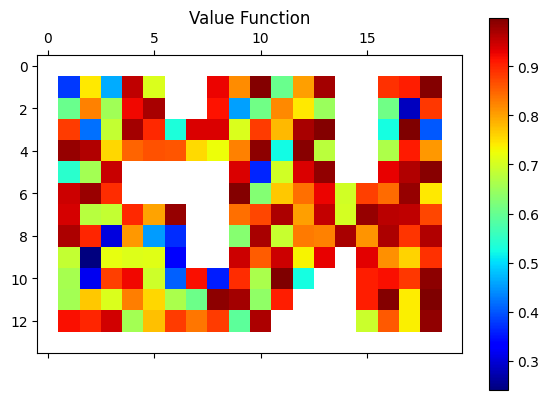

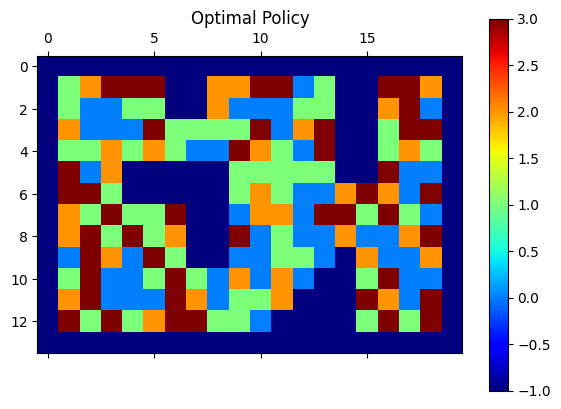

In [8]:
# Plot the value function (see included figure)
value_function = q.value_function()
plt.matshow(value_function, cmap = "jet")
plt.title('Value Function')
plt.colorbar()

# Plot policy (see included figure)
policy = q.get_optimal_policy()
plt.matshow(policy, cmap = "jet")
plt.title('Optimal Policy')
plt.colorbar()

## Test current Policy

Once the training is over, we can see what the robot has learnt to do. You can test it with other goal positions and other maps, to see of the policy is able to adapt to other situations.

In [ ]:
# generate an animation with the agent solving the maze






## Other environemnts

Create a new map (min size 15 x 15).

Answer:

* The policy you have just learned is able to solve this map?
* If not, the algorithm you have implemented is able to learn a new policy to solve this map? Demonstrate one or the other

## Submission

You must deliver this Python Interactive Notebook. The file must have the name q_learning_YOUR_NAME.ipynb. Also, you must do a report commenting the problems you encountered, a discussion on how the parameters affect the training and conclusions for the results obtained.

Make sure that all cells can be executed.